<a href="https://colab.research.google.com/github/zzuupp/Object_Detection-Segmentation/blob/main/pytorch_objdet/Pytorch_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection Íµ¨ÌòÑ

In [ ]:
import numpy as np
import pandas as pd
import os
import sys

In [ ]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes
from torch.utils.tensorboard import SummaryWriter

In [ ]:
Aqua_data_train_url  = '/content/drive/MyDrive/Aquarium Combined.v2-raw-1024.coco/train'
Aqua_data_valid_url = '/content/drive/MyDrive/Aquarium Combined.v2-raw-1024.coco/valid'
Aqua_data_test_url = '/content/drive/MyDrive/Aquarium Combined.v2-raw-1024.coco/test'

#### Î≥ÄÌôò Ìï®Ïàò ÏÉùÏÑ±.

In [ ]:
def get_transform(train = False):
    if train :
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p = 0.3), # 30% ÌôïÎ•†Î°ú Ï¢åÏö∞ Îí§ÏßëÍ∏∞.
            A.VerticalFlip(p = 0.3),   # 30% ÌôïÎ•†Î°ú ÏúÑÏïÑÎûò Îí§ÏßëÍ∏∞.
            A.RandomBrightnessContrast(p = 0.1), # 10% ÌôïÎ•†Î°ú Î∞ùÍ∏∞/ÎåÄÎπÑ Î¨¥ÏûëÏúÑ Î≥ÄÌôî.
            A.ColorJitter(p = 0.1), # 10% ÌôïÎ•†Î°ú ÏÉâÏÉÅ/Ï±ÑÎèÑ/Î™ÖÎèÑ Î≥ÄÌôî
            ToTensorV2() # NumPy => PyTorch Tensor Î≥ÄÌôò
        ], bbox_params = A.BboxParams(format = 'coco'))  #Í∞ùÏ≤¥ ÌÉêÏßÄÎäî Î∞îÏö¥Îî©Î∞ïÏä§ÎèÑ Ìï®Íªò Î≥ÄÌôòÌï¥ÏïºÌï®.

    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params = A.BboxParams(format = 'coco'))

    return transform

In [ ]:
# Ï∂îÌõÑ, DataLoaderÍ∞Ä Î∞∞ÏπòÎ•º ÎßåÎì§ Îïå, Í∞Å ÏÉòÌîåÏùÑ Ïñ¥ÎñªÍ≤å Î¨∂ÏùÑÏßÄ Ï†ïÏùòÌïòÎäî Ìï®Ïàò.
# DataLoader()Ìï®ÏàòÏùò ÌååÎùºÎØ∏ÌÑ∞, collate_fnÏóê Ïö∞Î¶¨Í∞Ä Ï†ïÏùòÌïú Í∞íÏùÑ ÎÑ£Ïùå(collate_fn)

def collate_fn(batch):
    """
    batch: ÌïôÏÉùÎ≥Ñ Îç∞Ïù¥ÌÑ∞ : [ ("Ï≤†Ïàò", 15), ("ÏòÅÌù¨", 16), ("ÎØºÏàò", 14) ]

    zip(*batch): ÌïÑÎìúÎ≥Ñ Îç∞Ïù¥ÌÑ∞ : [ ("Ï≤†Ïàò", "ÏòÅÌù¨", "ÎØºÏàò"), (15, 16, 14) ]
    """
    return tuple(zip(*batch))

#### Îç∞Ïù¥ÌÑ∞ÏÖã Í¥ÄÎ†® Ìï®Ïàò

In [ ]:

# datasets.VisionDataset: Ïù¥ÎØ∏ÏßÄ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÎßåÎì§ Îïå Í≥µÌÜµÏ†ÅÏúºÎ°ú ÌïÑÏöîÌïú Í∏∞Îä•(Î£®Ìä∏ Í≤ΩÎ°ú, transform, target_transform, Îç∞Ïù¥ÌÑ∞ Í∏∏Ïù¥, Ïù∏Îç±Ïã± Îì±)ÏùÑ Í∏∞Î≥∏ Ï†úÍ≥µÌïòÎäî Ï∂îÏÉÅ ÌÅ¥ÎûòÏä§
class AquariumDetection(datasets.VisionDataset):

    def __init__(self, root, split = 'train', transform = None, target_transform = None, transforms = None):
        # ÏÉÅÏÜç
        super().__init__(root, transforms, transform, target_transform)

        # Î≥ÄÏàò ÏßÄÏ†ï
        self.split = split
        # Í≤ΩÎ°ú ÏßÄÏ†ï
        self.coco = COCO(os.path.join(root, split, '_annotations.coco.json'))

        # Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò ÌååÏùºÏùò Ï°¥Ïû¨ÌïòÎäîÌÇ§Í∞í Í∞ÄÏ†∏Ïò§Í∏∞.
        self.ids = list(sorted(self.coco.imgs.keys()))

        # Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò ÌååÏùºÏóê ÏóÜÎäîÍ±¥ Ï†úÏô∏ÌïòÍ∏∞ ÏúÑÌï®Ïù∏Í±∞ Í∞ôÏùå.
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    # id : int
    def _load_image(self, id : int):

        """

        self.coco.imgs = {
            1: {"file_name": "0001.jpg", "height": 480, "width": 640},
            2: {"file_name": "0002.jpg", "height": 720, "width": 1280}
        }

        Ïù¥Îü∞ÏãùÏù∏Îç∞, self.coco.loadImgs(1) ÏùÑ Ìï¥Î≤ÑÎ¶¨Î©¥ (id = Ïà´Ïûê),
        [{'id': 1, 'file_name': '0001.jpg', 'height': 480, 'width': 640}]
        ÏôÄ Í∞ôÏù¥ Ìï¥Îãπ ÌòïÌÉúÏùò Ï†ïÎ≥¥Î•º Î¶¨Ïä§Ìä∏ ÌòïÌÉúÎ°ú Î∞òÌôòÌï®.
        Í∑∏ÎûòÏÑú Î¶¨Ïä§Ìä∏ Î≤óÍ∏∞Í∏∞ ÏúÑÌï¥ÏÑú [0]ÏÇ¨Ïö©.

        """

        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):

        """
        COCO Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò JSONÏùÄ Î≥¥ÌÜµ Îã§ÏùåÏùò Íµ¨Ï°∞Î•º ÏßÄÎãåÎã§.
        {
        "images": [
            {"id": 1, "file_name": "0001.jpg"},
            {"id": 2, "file_name": "0002.jpg"}
        ],

        "annotations": [
            {"id": 11, "image_id": 1, "category_id": 3, "bbox": [20, 35, 50, 60]},
            {"id": 12, "image_id": 1, "category_id": 1, "bbox": [200, 250, 60, 80]},
            {"id": 13, "image_id": 2, "category_id": 2, "bbox": [15, 25, 70, 90]}
        ],

        "categories": [
            {"id": 1, "name": "fish"},
            {"id": 2, "name": "shark"},
            {"id": 3, "name": "jellyfish"}
        ]
        }


        pycocotools.COCOÎ°ú ÏúÑ JSON ÏùΩÏùÑ Îïå,
        self.coco.anns = {
                            11: {"id": 11, "image_id": 1, "category_id": 3, "bbox": [20, 35, 50, 60]},
                            12: {"id": 12, "image_id": 1, "category_id": 1, "bbox": [200, 250, 60, 80]},
                            13: {"id": 13, "image_id": 2, "category_id": 2, "bbox": [15, 25, 70, 90]},
                         }


        ÏòàÎ•º Îì§Ïñ¥ÏÑú, Ïù¥ÎØ∏ÏßÄ 1Ïùò Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÎì§ÏùÑ Ï∞æÍ≥† Ïã∂ÏùÑ Îïå,

        ann_ids = self.coco.getAnnIds(imgIds=1) / print(ann_ids)
        print(ann_ids) -> [11, 12]
        * Ïù¥Í±¥ Îã®ÏàúÌûà ‚Äúimage_idÍ∞Ä 1Ïù∏ Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÎì§Ïùò id Î¶¨Ïä§Ìä∏‚ÄùÏòàÏöî.
        * Ï¶â, Ïù¥ÎØ∏ÏßÄ 1ÏóêÎäî annotation 11, 12Í∞Ä Ï°¥Ïû¨ÌïúÎã§Îäî Îúª.


        Ïù¥ÌõÑ, self.coco.loadAnns(ann_ids) Ìò∏Ï∂úÌïòÎ©¥,  -> anns = self.coco.loadAnns([11, 12])

        [
        {"id": 11, "image_id": 1, "category_id": 3, "bbox": [20, 35, 50, 60]},
        {"id": 12, "image_id": 1, "category_id": 1, "bbox": [200, 250, 60, 80]}
        ]

        loadAnns()Îäî Ï†ÑÎã¨Î∞õÏùÄ id Î¶¨Ïä§Ìä∏Î•º Ïù¥Ïö©Ìï¥ÏÑú
        self.coco.anns ÎîïÏÖîÎÑàÎ¶¨ ÏïàÏóêÏÑú Ìï¥Îãπ idÏóê Ìï¥ÎãπÌïòÎäî Îç∞Ïù¥ÌÑ∞Î•º Ï∞æÏïÑÏÑú Î¶¨Ïä§Ìä∏ ÌòïÌÉúÎ°ú Î∞òÌôòÌï©ÎãàÎã§.

        """
        # getAnnIds() ‚Üí Ïñ¥Îñ§ annotationÎì§Ïù¥ ÏûàÎäîÏßÄ idÎßå ÏïåÏïÑÎÉÑ
        # loadAnns() ‚Üí Í∑∏ idÎì§Î°ú Ïã§Ï†ú ÎÇ¥Ïö©(Î∞ïÏä§ Ï¢åÌëú, ÌÅ¥ÎûòÏä§ Îì±)ÏùÑ Ï°∞Ìöå
        return self.coco.loadAnns(self.coco.getAnnIds(id))


    # Í∞ùÏ≤¥Î•º Î¶¨Ïä§Ìä∏Ï≤òÎüº Ïù∏Îç±Ïã±Ìï† Ïàò ÏûàÍ≤å : __getitem__
    # Ï¶â, ÏõêÌïòÎäî Ïù∏Îç±Ïä§Ïóê Ìï¥ÎãπÌïòÎäî Îç∞Ïù¥ÌÑ∞(Ïù¥ÎØ∏ÏßÄ, ÎùºÎ≤®) Î∞òÌôò / Î¶¨Ïä§Ìä∏Ï≤òÎüº Ïù∏Îç±Ïä§Î°ú Îç∞Ïù¥ÌÑ∞Î•º Í∫ºÎÇ¥Îäî Î≤ï Ï†ïÏùò
    def __getitem__(self,index):

        # ids : Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÏù¥ ÏûàÎäîÍ≤ÉÎì§Îßå Ï∂îÎ¶¨Í≤å Îê®.
        id = self.ids[index]


        # ÎÇ¥Î∂ÄÏóêÏÑú Ï†ëÍ∑ºÌïòÍ≤å ÏÑ§Ï†ïÌïú ÏΩîÎìú
        image = self._load_image(id)
        target= self._load_target(id) #Ïù¥ÎØ∏ÏßÄÏóê Ï°¥Ïû¨ÌïòÎäî Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÏùò Î™®Îì†Ï†ïÎ≥¥ Ï°∞Ìöå (Î∞ïÏä§ Ï¢åÌëú, ÌÅ¥ÎûòÏä§ Îì±)
        target = copy.deepcopy(self._load_target(id)) # ÌÜµÎ≥µÏÇ¨ ('ÏßÑÏßú'Í∞Ä Î≥ÄÍ≤ΩÎêòÏßÄ ÏïäÎèÑÎ°ù)

        # target = Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖòÌååÏùº, Ïó¨Í∏∞ÏóêÏÑú boundingbox, idÎßå ÎπºÏÑú Ï†ÄÏû•.
        boxes = [t['bbox'] + [t['category_id']] for t in target]


        # transformsÎ•º Ï†ÅÏö©Ìïú Í≤ΩÏö∞ÏôÄ ÏïÑÎãå Í≤ΩÏö∞.
        if self.transforms is not None:
            # ÏïûÏóêÏÑú Î≥∏ Ïù¥ÎØ∏ÏßÄ Î≥ÄÌôò.
            transformed = self.transforms(image = image, bboxes = boxes)


        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        # ‚ùóÔ∏è PyTorch / Albumentations / Î™®Îç∏Îì§ÏùÄ XYXY ÌòïÏãù (xmin, ymin, xmax, ymax)ÏùÑ ÏõêÌï©ÎãàÎã§.
        # coco boxÎäî bbox = [x_min, y_min, width, height] ÏôÄ Í∞ôÏù¥ Ï†ïÏùòÎêòÏñ¥ ÏûàÏùå.
        '''
        Í∑∏ÎûòÏÑú x_minÏùÄ Ìï≠ÏÉÅ Í∑∏ Î∞ïÏä§ÏóêÏÑú Í∞ÄÏû• ÏôºÏ™ΩÏóê ÏûàÎäî xÏ¢åÌëú
        ‚Üí Ï¶â, xÏ¢åÌëú Ï§ë ÏµúÏÜåÍ∞í

        y_minÏùÄ Ìï≠ÏÉÅ Í∑∏ Î∞ïÏä§ÏóêÏÑú Í∞ÄÏû• ÏúÑÏ™ΩÏóê ÏûàÎäî yÏ¢åÌëú
        ‚Üí Ï¶â, yÏ¢åÌëú Ï§ë ÏµúÏÜåÍ∞í

        '''

        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax  = ymin + box[3]

            # ÏôºÏ™Ω ÏúÑ : xmin,y_min  //  Ïò§Î•∏Ï™Ω ÏïÑÎûò : xmax, ymax
            new_boxes.append([xmin, ymin, xmax, ymax])


        boxes = torch.tensor(new_boxes, dtype = torch.float32)

        # Î≥ÄÌôòÍ∞íÏùÑ Îã¥ÏùÑ Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±.
        targ = {}
        targ['boxes'] = boxes


        # PyTorchÏùò Í∞ùÏ≤¥ ÌÉêÏßÄ Î™®Îç∏Îì§(Faster R-CNN, SSD, YOLO Îì±)ÏùÄ ÎùºÎ≤®(label) Í∞íÏùÑ Ï†ïÏàòÌòï(LongTensor) ÏúºÎ°ú Í∏∞ÎåÄ
        # Ï¶â, float(ÏÜåÏàòÌòï)Ïù¥ÎÇò bool ÌÉÄÏûÖÏù¥Î©¥ ÌïôÏäµ Ïãú ÏóêÎü¨Í∞Ä ÎÇòÏöî.
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype = torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:, 0])

        # iscrowd : Î∞îÏö¥Îî© Î∞ïÏä§Í∞Ä Í∞úÎ≥Ñ Í∞ùÏ≤¥Ïù∏ÏßÄ, Ïó¨Îü¨ Í∞ùÏ≤¥Í∞Ä Î≠âÏπú Îç©Ïñ¥Î¶¨Ïù∏ÏßÄ (0: ÏùºÎ∞ò Í∞ùÏ≤¥, 1 Íµ∞Ïßë Í∞ùÏ≤¥)
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype = torch.int64)

        # Ïù¥ÎØ∏ÏßÄ ÌîΩÏÖÄÍ∞í Ï†ïÍ∑úÌôî 0~255
        return image.div(255), targ

    # Îç∞Ïù¥ÌÑ∞ÏÖãÏùò Ï†ÑÏ≤¥ ÌÅ¨Í∏∞ Î∞òÌôò(Ïù¥ÎØ∏ÏßÄ Í∞úÏàò)
    def __len__(self):
        return len(self.ids)


## Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Î∞è ÌôïÏù∏.


In [ ]:
dataset_path = '/content/drive/MyDrive/Aquarium Combined.v2-raw-1024.coco'

# coco ÌòïÏãùÏùò Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò json ÌååÏùº ÏùΩÍ∏∞.
coco = COCO(os.path.join(dataset_path, 'train','_annotations.coco.json'))

# Ïπ¥ÌÖåÍ≥†Î¶¨ ÌôïÏù∏.
categories = coco.cats

# Í∞úÏàò
n_classes = len(categories.keys())

# ÌôïÏù∏
categories

loading annotations into memory...
Done (t=4.01s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [ ]:
# train data
train_dataset = AquariumDetection(root = dataset_path, transforms = get_transform(train = True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


* ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏.

In [ ]:
# Ïù¥ÎØ∏ÏßÄ 1Í∞ú ÏûÑÏùòÎ°ú ÏÑ§Ï†ï.
sample = train_dataset[2]

# Ï≤®Í≥† : ÏïàÏóê Îã¥Í≤® ÏûàÎäî Ï†ïÎ≥¥ ÌôïÏù∏.
sample

(tensor([[[0.0902, 0.0941, 0.0980,  ..., 0.0824, 0.0784, 0.0745],
          [0.0902, 0.0941, 0.0941,  ..., 0.0784, 0.0745, 0.0745],
          [0.1020, 0.1020, 0.1020,  ..., 0.0784, 0.0745, 0.0706],
          ...,
          [0.4941, 0.4902, 0.4863,  ..., 0.7647, 0.7765, 0.7843],
          [0.4980, 0.4941, 0.4902,  ..., 0.8039, 0.8431, 0.8824],
          [0.4745, 0.4824, 0.4941,  ..., 0.7294, 0.7765, 0.8353]],
 
         [[0.2353, 0.2392, 0.2431,  ..., 0.1686, 0.1647, 0.1608],
          [0.2353, 0.2392, 0.2392,  ..., 0.1686, 0.1608, 0.1608],
          [0.2471, 0.2471, 0.2471,  ..., 0.1647, 0.1608, 0.1569],
          ...,
          [0.4471, 0.4431, 0.4392,  ..., 0.6667, 0.6784, 0.6863],
          [0.4510, 0.4471, 0.4431,  ..., 0.6980, 0.7373, 0.7765],
          [0.4275, 0.4353, 0.4471,  ..., 0.6235, 0.6706, 0.7294]],
 
         [[0.3098, 0.3137, 0.3176,  ..., 0.2235, 0.2196, 0.2157],
          [0.3098, 0.3137, 0.3137,  ..., 0.2235, 0.2157, 0.2157],
          [0.3216, 0.3216, 0.3216,  ...,

/tmp/ipython-input-3974730949.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(sample[0] * 255, dtype = torch.uint8)


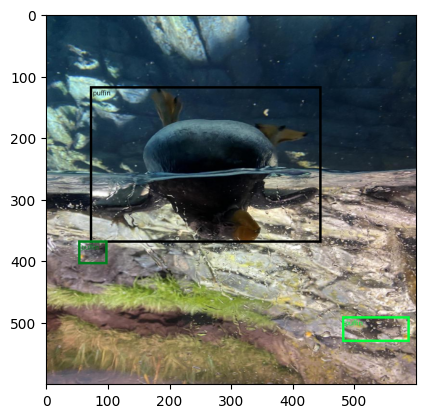

In [ ]:
# Ïù¥ÎØ∏ÏßÄ ÌôïÏù∏.
# Ï†ïÍ∑úÌôî(255)Îêú Ïù¥ÎØ∏ÏßÄ ÌååÏùºÏùÑ Ïó≠Ï†ïÍ∑úÌôî ÌïòÍ∏∞. ( * 255)
img_int = torch.tensor(sample[0] * 255, dtype = torch.uint8)

# * draw_bounding_boxes() : Ïù¥ÎØ∏ÏßÄ(torch.Tensor ÌòïÌÉú)Ïùº Îïå, Ìï¥Îãπ Ïù¥ÎØ∏ÏßÄ ÏúÑÏóê Î∞îÏö¥Îî© Î∞ïÏä§Î•º Í∑∏Î†§Ï£ºÎäî ÏãúÍ∞ÅÌôî.
plt.imshow(
    draw_bounding_boxes(
                        img_int,
                        sample[1]['boxes'],
                         [classes[i] for i in sample[1]['labels']],
                        width = 4).permute(1, 2, 0))

In [ ]:
#### pytorch ÏóêÏÑú Ï†úÍ≥µÌïòÎäî Î™®Îç∏ Îã§Ïö¥Î∞õÏïÑ ÏÇ¨Ïö©.
# ÌååÏù¥ÌÜ†ÏπòÎäî Î™®Îç∏Îßå Ï†úÍ≥µÌï®, ÎÇòÎ®∏ÏßÄÎäî ÏÑ§Ï†ïÌï¥Ïïº Ìï®.



model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained = True)



# in_features : Î∂ÑÎ•òÎ™®Îç∏ Ìó§ÎìúÏóê Îì§Ïñ¥Í∞ÄÎäî ÏûÖÎ†•ÌîºÏ≤òÏàò ÏÑ§Ï†ï.
# why? ÎÇ¥ Îç∞Ïù¥ÌÑ∞ ÌÅ¥ÎûòÏä§ ÏàòÏóê ÎßûÍ≤å Ï∂úÎ†•Ï∏µÏùÑ ÍµêÏ≤¥Ìï¥Ïïº ÌïòÍ∏∞ ÎïåÎ¨∏.
'''
roi_heads	Region-of-Interest Ìó§Îìú: Í∞êÏßÄÎêú ÌõÑÎ≥¥ ÏòÅÏó≠(ROI)ÏùÑ Î∂ÑÎ•ò¬∑Î∞ïÏä§ ÌöåÍ∑ÄÌïòÎäî Î∂ÄÎ∂Ñ
box_predictor	ROI Heads ÏïàÏùò ÏµúÏ¢Ö ÏòàÏ∏°Í∏∞(classifier + regressor)
cls_score	ÌÅ¥ÎûòÏä§ ÌôïÎ•†ÏùÑ ÏòàÏ∏°ÌïòÎäî nn.Linear Ï∏µ
in_features	cls_score Ï∏µÏóê Îì§Ïñ¥Í∞ÄÎäî ÏûÖÎ†• Î≤°ÌÑ∞ Ï∞®Ïõê Ïàò
'''
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74.2M/74.2M [00:00<00:00, 230MB/s]


train_loader ÏÉùÏÑ±.

In [ ]:
train_loader = DataLoader(train_dataset,
                          batch_size=4,
                          shuffle = True,
                          num_workers = 2,
                          collate_fn = collate_fn)

In [ ]:
images, targets = next(iter(train_loader))

In [ ]:
images

(tensor([[[0.2510, 0.2510, 0.2510,  ..., 0.5373, 0.5451, 0.5529],
          [0.2471, 0.2471, 0.2510,  ..., 0.5451, 0.5490, 0.5529],
          [0.2431, 0.2471, 0.2471,  ..., 0.5608, 0.5608, 0.5608],
          ...,
          [0.2824, 0.2941, 0.2902,  ..., 0.4667, 0.4549, 0.4588],
          [0.2824, 0.2941, 0.3020,  ..., 0.4824, 0.4706, 0.4431],
          [0.2824, 0.2902, 0.3020,  ..., 0.5098, 0.4902, 0.4235]],
 
         [[0.2510, 0.2510, 0.2510,  ..., 0.7725, 0.7804, 0.7882],
          [0.2471, 0.2471, 0.2510,  ..., 0.7804, 0.7843, 0.7882],
          [0.2431, 0.2471, 0.2471,  ..., 0.7961, 0.7961, 0.7961],
          ...,
          [0.3098, 0.3176, 0.3176,  ..., 0.6784, 0.6667, 0.6706],
          [0.3098, 0.3216, 0.3294,  ..., 0.6941, 0.6824, 0.6549],
          [0.3098, 0.3176, 0.3294,  ..., 0.7216, 0.7020, 0.6353]],
 
         [[0.2196, 0.2196, 0.2196,  ..., 0.6745, 0.6824, 0.6902],
          [0.2157, 0.2157, 0.2196,  ..., 0.6824, 0.6863, 0.6902],
          [0.2118, 0.2157, 0.2157,  ...,

In [ ]:
targets

({'boxes': tensor([[444.1406,  76.5625, 473.4375,  99.2188],
          [492.1875, 542.9688, 519.7266, 571.0938],
          [475.7812, 554.6875, 499.8047, 599.2188],
          [410.1562, 513.2812, 428.9062, 568.7500],
          [346.8750, 428.9062, 379.1016, 468.7500],
          [360.3516, 400.7812, 373.2422, 430.4688],
          [189.8438, 471.0938, 212.1094, 513.2812],
          [123.0469, 248.4375, 152.9297, 296.8750],
          [206.8359,  54.6875, 230.2734, 100.0000]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'image_id': tensor([259, 259, 259, 259, 259, 259, 259, 259, 259]),
  'area': tensor([ 663.7573,  774.5361, 1069.7937, 1040.0391, 1284.0271,  382.6904,
           939.3311, 1447.4487, 1062.0117]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])},
 {'boxes': tensor([[  1.5625, 203.3203, 502.3438, 401.9531],
          [  0.0000, 427.7344, 104.6875, 493.9453]]),
  'labels': tensor([5, 7]),
  'image_id': tensor([163, 163]),
  'area': tensor([99471.5859,  6931.4575]),
  

In [ ]:
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]

In [ ]:
len(images)

4

In [ ]:
images

[tensor([[[0.2510, 0.2510, 0.2510,  ..., 0.5373, 0.5451, 0.5529],
          [0.2471, 0.2471, 0.2510,  ..., 0.5451, 0.5490, 0.5529],
          [0.2431, 0.2471, 0.2471,  ..., 0.5608, 0.5608, 0.5608],
          ...,
          [0.2824, 0.2941, 0.2902,  ..., 0.4667, 0.4549, 0.4588],
          [0.2824, 0.2941, 0.3020,  ..., 0.4824, 0.4706, 0.4431],
          [0.2824, 0.2902, 0.3020,  ..., 0.5098, 0.4902, 0.4235]],
 
         [[0.2510, 0.2510, 0.2510,  ..., 0.7725, 0.7804, 0.7882],
          [0.2471, 0.2471, 0.2510,  ..., 0.7804, 0.7843, 0.7882],
          [0.2431, 0.2471, 0.2471,  ..., 0.7961, 0.7961, 0.7961],
          ...,
          [0.3098, 0.3176, 0.3176,  ..., 0.6784, 0.6667, 0.6706],
          [0.3098, 0.3216, 0.3294,  ..., 0.6941, 0.6824, 0.6549],
          [0.3098, 0.3176, 0.3294,  ..., 0.7216, 0.7020, 0.6353]],
 
         [[0.2196, 0.2196, 0.2196,  ..., 0.6745, 0.6824, 0.6902],
          [0.2157, 0.2157, 0.2196,  ..., 0.6824, 0.6863, 0.6902],
          [0.2118, 0.2157, 0.2157,  ...,

In [ ]:
targets

[{'boxes': tensor([[444.1406,  76.5625, 473.4375,  99.2188],
          [492.1875, 542.9688, 519.7266, 571.0938],
          [475.7812, 554.6875, 499.8047, 599.2188],
          [410.1562, 513.2812, 428.9062, 568.7500],
          [346.8750, 428.9062, 379.1016, 468.7500],
          [360.3516, 400.7812, 373.2422, 430.4688],
          [189.8438, 471.0938, 212.1094, 513.2812],
          [123.0469, 248.4375, 152.9297, 296.8750],
          [206.8359,  54.6875, 230.2734, 100.0000]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'image_id': tensor([259, 259, 259, 259, 259, 259, 259, 259, 259]),
  'area': tensor([ 663.7573,  774.5361, 1069.7937, 1040.0391, 1284.0271,  382.6904,
           939.3311, 1447.4487, 1062.0117]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])},
 {'boxes': tensor([[  1.5625, 203.3203, 502.3438, 401.9531],
          [  0.0000, 427.7344, 104.6875, 493.9453]]),
  'labels': tensor([5, 7]),
  'image_id': tensor([163, 163]),
  'area': tensor([99471.5859,  6931.4575]),
  

## Ï¥àÍ∏∞ÌïôÏäµ Î∞è Í≤∞Í≥º ÏÇ¥Ìé¥Î≥¥Í∏∞.


In [ ]:
output = model(images, targets)
output

{'loss_classifier': tensor(2.0173, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.5063, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0509, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0147, grad_fn=<DivBackward0>)}

#### ÏúÑ ÎÇ¥Ïö©Ïù¥ Î¨¥ÏóáÏùÑ ÏùòÎØ∏ÌïòÎäîÍ∞Ä?    

```
'loss_classifier': tensor(2.3382, grad_fn=<NllLossBackward0>),
'loss_box_reg': tensor(0.7284, grad_fn=<DivBackward0>),
'loss_objectness': tensor(0.1824, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
'loss_rpn_box_reg': tensor(0.0366, grad_fn=<DivBackward0>)
```


* loss_classifier : ROI HeadÏùò ÌÅ¥ÎûòÏä§ Î∂ÑÎ•ò Ïò§Ï∞®.</br>
‚Üí ‚ÄúÏ†úÏïàÎêú ROIÍ∞Ä Ïñ¥Îñ§ ÌÅ¥ÎûòÏä§Ïù∏ÏßÄ ÎßûÌòîÎäîÍ∞Ä?‚Äù</br>
Ï¥àÍ∏∞ ÌïôÏäµÏù¥Î©¥ ÌÅ∞ Í∞íÏù¥ Ï†ïÏÉÅÏûÑ, ÌïôÏäµÏù¥ ÏßÑÌñâÎêòÎèÑ, 2Ïù¥ÏÉÅ Ï†ÑÌòÄ ÏïàÎÇ¥Î†§Í∞à Í≤ΩÏö∞ Îã§ÏùåÏùÑ Í≥†Î†§Ìï®.
    * ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï, ÎùºÎ≤® Ïò§Î•ò, ÎùºÎ≤® dtype(int64) Î¨∏Ï†ú, ÎÑàÎ¨¥ Í∞ïÌïú Ï¶ùÍ∞ï Îì± ÏùòÏã¨.


* loss_box_reg ROI : HeadÏùò Î∞ïÏä§ ÌöåÍ∑Ä Ïò§Ï∞®(Smooth L1/IoU Í≥ÑÏó¥) </br>
‚Üí ‚ÄúROIÏùò ÏµúÏ¢Ö Î∞ïÏä§Í∞Ä GTÏóê ÏñºÎßàÎÇò Í∑ºÏ†ë?‚Äù </br>
Ï¥àÍ∏∞Ïóî 0.5~1.xÎåÄÍ∞Ä ÌùîÌï®. ÌïôÏäµÎêòÎ©¥ ÏôÑÎßåÌïòÍ≤å ÌïòÍ∞ïÌï¥Ïïº Ï†ïÏÉÅ, ÏßÄÏÜçÏ†ÅÏúºÎ°ú ÎÜíÍ≤å Í≥†Ï∞©ÎêúÎã§Î©¥...
    * ÏûÖÎ†• Ìï¥ÏÉÅÎèÑ/Ïä§ÏºÄÏùº, ROI ÏÉòÌîåÎßÅ, Ï¢åÌëú Ìè¨Îß∑(XYXY ÎßûÎäîÏßÄ), ÏûòÎ™ªÎêú bbox(ÏùåÏàò/ÏòÅÏó≠ 0) Ï†êÍ≤Ä.


* loss_objectness : RPNÏùò Í∞ùÏ≤¥ÏÑ±(objectness) Ïò§Ï∞®(BCEWithLogits). </br>
‚Üí ‚ÄúÏïµÏª§Í∞Ä ‚ÄòÎ¨ºÏ≤¥ ÏûàÏùå/ÏóÜÏùå‚ÄôÏùÑ Ïûò Í∞ÄÎ†§ÎÉàÎäîÍ∞Ä?‚Äù</br>
RPNÏùò Î¨ºÏ≤¥/Î∞∞Í≤Ω Íµ¨Î∂ÑÏùÄ Î≥¥ÌÜµ Îπ®Î¶¨ ÏïàÏ†ïÎê®. 0.1~0.3ÎåÄÎ©¥ ÎÇòÏÅòÏßÄ ÏïäÏùÄ Ìé∏.
    * Ïù¥ Í∞íÎßå ÎπÑÏ†ïÏÉÅÏ†ÅÏúºÎ°ú ÎÜíÏúºÎ©¥ ÏïµÏª§ Ïä§ÏºÄÏùº/ÎπÑÏú®Ïù¥ Îç∞Ïù¥ÌÑ∞ÏôÄ Î∂àÏùºÏπò(ÏûëÏùÄ Î¨ºÏ≤¥ ÏúÑÏ£ºÏù∏Îç∞ ÏïµÏª§Í∞Ä ÌÅº Îì±) Í∞ÄÎä•.




* loss_rpn_box_reg : RPNÏùò Î∞ïÏä§ ÌöåÍ∑Ä Ïò§Ï∞®. </br>
‚Üí ‚ÄúÏ¥àÍ∏∞ Ï†úÏïà Î∞ïÏä§(anchor‚Üíproposal) Î≥¥Ï†ïÏù¥ GTÏôÄ ÏñºÎßàÎÇò Í∑ºÏ†ë?‚Äù </br>
 ÍΩ§ ÎÇÆÏùå. RPN ÌöåÍ∑ÄÎäî ÎåÄÍ∞ú Îπ†Î•¥Í≤å ÏïàÏ†ïÎêòÎäî Ìé∏.
    * ÎÑàÎ¨¥ 0Ïóê Í∞ÄÍπùÍ≤å Îπ®Î¶¨ Îñ®Ïñ¥ÏßÄÎ©¥ Ïò§Î≤ÑÏä§Î¨¥Îî©/ÌïôÏäµÎ•†/Ï†ïÍ∑úÌôîÎèÑ Í∞ôÏù¥ ÌôïÏù∏(Î≥¥ÌÜµÏùÄ OK).

In [ ]:
# Pytorch : Î™®Îç∏Í≥º Îç∞Ïù¥ÌÑ∞Í∞Ä Í∞ôÏùÄ deviceÏóê ÏûàÏñ¥ÏïºÎßå Ïó∞ÏÇ∞ Í∞ÄÎä•.
# CPU Î©îÎ™®Î¶¨Ïóê Ï°¥Ïû¨ÌïòÎäîÍ±∏ Î™®Îëê GPU Î©îÎ™®Î¶¨Ïóê Ïò¨Î¶¥Í∫ºÏûÑ.
# Ï¶â, ‚ÄúÎ™®Îç∏Ïùò Î™®Îì† ÌååÎùºÎØ∏ÌÑ∞(weight, bias Îì±)Î•º ÏßÄÏ†ïÌïú deviceÎ°ú Î≥µÏÇ¨ÌïúÎã§.‚Äù

device = torch.device('cuda')
model = model.to(device)

‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏èÌòÑÏóÖ ÌïÑÏàò Ìå®ÌÑ¥ ÏΩîÎìú (params ....)

In [ ]:
# model.parameters : Î™®Îì† ÌååÎùºÎØ∏ÌÑ∞ ÏßÄÏ†ï.
# requires_grad : Ïù¥ ÌÖêÏÑúÍ∞Ä Ïó≠Ï†ÑÌåå(backprop) Î•º ÌÜµÌï¥ ÌïôÏäµ(gradient Í≥ÑÏÇ∞) Îê†ÏßÄ ÎßêÏßÄ‚ÄùÎ•º ÏßÄÏ†ïÌïòÎäî ÌîåÎûòÍ∑∏ / PyTorch Î™®Îì† ÌÖêÏÑúÏóê Ï°¥Ïû¨.
# requires_grad=True ‚Üí ÌïôÏäµ ÎåÄÏÉÅ
# requires_grad=False ‚Üí ÌïôÏäµ Ï§ë ÏóÖÎç∞Ïù¥Ìä∏ Ïïà Ìï® (Í≥†Ï†ï)

# Î™®Îç∏Ïùò Î™®Îì† ÌååÎùºÎØ∏ÌÑ∞ Ï§ëÏóêÏÑú ‚Äúrequires_grad=TrueÏù∏ Í≤ÉÎßå Í≥®ÎùºÏÑú Î¶¨Ïä§Ìä∏Î°ú Î™®ÏúºÎäî ÏΩîÎìú‚Äù
params = [p for p in model.parameters() if p.requires_grad]

In [ ]:
# SGD : Í≤ΩÏÇ¨ÌïòÍ∞ïÎ≤ï(LossÍ∞Ä Ï§ÑÏñ¥ÎìúÎäî Î∞©Ìñ•‚ÄùÏúºÎ°ú ÌååÎùºÎØ∏ÌÑ∞Î•º Ï°∞Í∏àÏî© Ï°∞Ï†ïÌïòÎäî Î∞©Î≤ï)

optimizer = torch.optim.SGD(params,  # üëâ ÌïôÏäµ Í∞ÄÎä•Ìïú ÌååÎùºÎØ∏ÌÑ∞(weight, bias Îì±)Îßå ÏòµÌã∞ÎßàÏù¥Ï†ÄÏóê Ï†ÑÎã¨, Ïù¥ Í∞íÎì§Îßå ÏÜêÏã§Ïóê Îî∞Îùº ÏóÖÎç∞Ïù¥Ìä∏ Ìï¥Ï£ºÏÑ∏Ïöî.
                            lr = 0.01, # ÌïôÏäµÎ•†, ÌååÎùºÎØ∏ÌÑ∞Î•º Ìïú Î≤à ÏóÖÎç∞Ïù¥Ìä∏Ìï† Îïå ÏñºÎßàÎßåÌÅº Ïù¥ÎèôÌï†ÏßÄ Í≤∞Ï†ïÌïòÎäî Ïä§ÌÖù ÌÅ¨Í∏∞.Î≥¥ÌÜµ 0.001 ~ 0.01 ÏÇ¨Ïù¥ÏóêÏÑú Ïã§ÌóòÏ†ÅÏúºÎ°ú Í≤∞Ï†ï ( ÎÑàÎ¨¥ÏûëÏúºÎ©¥ Ïò§ÎûòÍ±∏Î†§Ïöî)
                            momentum = 0.9, # Ïù¥Ï†Ñ Îã®Í≥ÑÏùò Ïù¥Îèô Î∞©Ìñ•ÏùÑ Í¥ÄÏÑ±Ï≤òÎüº Î∞òÏòÅÌï¥ÏÑú ÏßÑÎèôÏùÑ Ï§ÑÏù¥Í≥† Îπ†Î•¥Í≤å ÏàòÎ†¥, 0.9Î©¥, Ïù¥Ï†Ñ Ïä§ÌÖùÏùò 90% Ï†ïÎèÑÎ•º Ïù¥Î≤à Ïä§ÌÖù Î∞©Ìñ•Ïóê Î∞òÏòÅ
                            nesterov = True, # Î≥¥ÌÜµ.... momentum=0.9, nesterov=True Ï°∞Ìï©Ïù¥ SGDÏùò ‚ÄúÎ≤†Ïä§Ìä∏ ÌîÑÎûôÌã∞Ïä§‚Äù Ï°∞Ìï©
                            weight_decay = 1e-4) # ÌïôÏäµ Ï§ë ÌååÎùºÎØ∏ÌÑ∞(Í∞ÄÏ§ëÏπò)Í∞Ä ÎÑàÎ¨¥ Ïª§ÏßÄÏßÄ ÏïäÍ≤å Ï†úÏñ¥ÌïòÎäî Í∑úÏ†úÌï≠. Ï¶â, Ïò§Î≤ÑÌîºÌåÖ Î∞©ÏßÄÏö©.

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in  images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        # Î™®Îç∏ Ï†ÑÏ≤¥ÏóêÏÑú Í≥ÑÏÇ∞Îêú Ï¥ù ÏÜêÏã§Í∞í.(Î∂ÑÎ•ò + ÌöåÍ∑Ä + RPN Îì±)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f'')

SyntaxError: incomplete input (ipython-input-3648137625.py, line 2)